# Additional materials
This file contains the source code, comments to it and instructions for building.
It is also assumed, that the user already has [python](https://www.python.org/downloads/) downloaded and [pip](https://pip.pypa.io/en/stable/installation/) installed. If you are using other package managers such as Homebrew or Conda, you'll have to ensure that all used libraries are installed on your device

## Getting and processing data for the graph
As a result of human imperfection, there was a need to process data automatically. This removes the human factor and make the work way more easier. However, the creation of such a system can be very laborious, long-drawn-out, requiring patience and, in total, ungrateful. But in all we can get a very pretty result))

### Installing libraries
I used 3 libraries to handle, parse and process data, respectively, [Requests](https://pypi.org/project/requests/), [Beautiful Soup](https://pypi.org/project/beautifulsoup4/) and [Pandas](https://pypi.org/project/pandas/).

To parse the HTML code in Beatifoul Soup, [lxml](https://pypi.org/project/lxml/) is needed.

Also I used the [regular expression](https://docs.python.org/3/library/re.html) library to parse some strings according to a specific pattern.

To construct and compute my graph I used [Networkx](https://pypi.org/project/networkx/) – a tool for working with complex networks, which is very helpful when we have many nodes and edges in our graph.

Finally, to export my graph into my $\rm\TeX$ cleanup, I used [tikzplotlib](https://pypi.org/project/tikzplotlib/). It will convert my graph object to a PGFPlot figure.

In [ ]:
%pip install requests
%pip install beautifulsoup4
%pip install pandas
%pip install lxml
#
%pip install pyproj
%pip install utm
%pip install networkx
#
%pip install tikzplotlib

### Importing libraries
Is there something to explain? :)

In [248]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re
#
import numpy as np
from pyproj import Transformer
import utm
import networkx as nx
import matplotlib.pyplot as plt
#
import tikzplotlib

### Getting countries
It will be fabulous to have a list of land borders of European countries on Wiki in one, but they are separated, so the hard way you choose :(

We will first send a request to the [page](https://simple.wikipedia.org/wiki/List_of_European_countries) with the table of all European countries and check the status code (not necessary for this case, but useful in general):

In [221]:
r_countries = requests.get(
    'https://simple.wikipedia.org/wiki/List_of_European_countries')
if r_countries.status_code != 200:  # means that the scrapping is not legally possible
    print("Error: website doesn't allow to download the source code")
    quit

We'll create a Beautiful Soup object by reading and parsing the text from our request and then find the part with the table in it.
Thereafter we have to delete (decompose) all data under tag 'sup' which stands for superscript which is used for footnotes in Wikipedia to "clear" countries name:

In [222]:
soup_countries = BeautifulSoup(r_countries.text, 'html.parser')
table_countries = soup_countries.find('table', {'class': "wikitable"})
for data in table_countries(['sup']):
    data.decompose()

Finally we can build our dataframe. First we read the info from our table into a list of DataFrame objects and then build the DataFrame itself.
Then I deleted some columns I don't need and rename the column with countries to "Country". At last, I sorted the countries and reset the indexes:

In [223]:
df_countries = pd.read_html(str(table_countries))
df_countries = pd.DataFrame(df_countries[0])
df_countries.drop(df_countries.columns[[1, 2, 3]], axis=1, inplace=True)
df_countries.columns = ['Country', 'Capital']
df_countries = df_countries.sort_values(by=['Country'])
df_countries.reset_index(drop=True, inplace=True)


You can easily check your DataFrame just by printing the object or using the method "head" to print the *n* first rows:

In [224]:
df_countries.head()

,Country,Capital
0,Albania,Tirana
1,Andorra,Andorra la Vella
2,Armenia,Yerevan
3,Austria,Vienna
4,Belarus,Minsk


### Getting borders
We'll get the data from the [table](https://en.wikipedia.org/wiki/List_of_countries_and_territories_by_land_borders) with all countries and their land borders and clear it (country and borders remain):

In [225]:
r_borders = requests.get(
    'https://en.wikipedia.org/wiki/List_of_countries_and_territories_by_land_borders')
if r_borders.status_code != 200:
    print("Error: website doesn't allow to download the source code")
    quit

soup_borders = BeautifulSoup(r_borders.text, 'html.parser')
table_borders = soup_borders.find('table', {'class': "wikitable"})
for data in table_borders(['sup']):
    data.decompose()
df_borders = pd.read_html(str(table_borders))
df_borders = pd.DataFrame(df_borders[0])
df_borders = df_borders.droplevel(0, axis=1)
df_borders.drop(df_borders.columns[[1, 2, 3, 4]], axis=1, inplace=True)
df_borders.columns = ['Country', 'Borders']

Unfortunately, there is some data to correct manually: four countries are duplicated because of colonial territories and have some additional text. We'll rename them and after this merge it with our list of European countries:

In [226]:
df_borders.at[47, 'Country'] = 'Denmark'
df_borders.at[63, 'Country'] = 'France'
df_borders.at[131, 'Country'] = 'Netherlands'
df_borders.at[194, 'Country'] = 'United Kingdom'

df = df_countries.merge(df_borders, how='left')

The most hard thing was to split the countries in the `Borders` column, because there was a clear pattern:

Country: border lenght in km (border lenght in mi) 

But there were also some exceptions due to wich the *regex* pattern turned into this:

```python
r'[ \(0-9\)]*:[\s\(a-zA-Z\)]*\s[0-9.,]+\skm\s\([0-9.,]+\smi\)\s?[\(including 0.05\xa0km segment with Åland\)\xa0]*'
```

After a while I found a solution: I split every string by a colon (which occurs only after a country name) or by a `\xa0` — a symbol which stands before a country name (apparently, this is what the newline sign has become). After that I got in every cell (except island states) an array of string. I ran over each string, cleaning it one more time with a regex pattern (because there were STILL some exceptions) and comparing it with the list of European countries:

In [227]:
for i in range(len(df['Borders'])):
    if type(df['Borders'][i]) == str:
        df['Borders'][i] = re.split(':|\xa0', df['Borders'][i])
        new_data = []
        for elem in df['Borders'][i]:
            match = re.search('[A-Z][a-zA-Z ]+', elem)
            if (match) and df['Country'].str.contains(match.group(0).strip()).any():
                new_data.append(match.group(0).strip())
        df['Borders'][i] = new_data

df.head()

,Country,Capital,Borders
0,Albania,Tirana,"[Greece, Kosovo, North Macedonia, Montenegro]"
1,Andorra,Andorra la Vella,"[France, Spain]"
2,Armenia,Yerevan,"[Georgia, Turkey]"
3,Austria,Vienna,"[Czech Republic, Germany, Hungary, Italy, Liec..."
4,Belarus,Minsk,"[Latvia, Lithuania, Poland, Russia, Ukraine]"


### Getting geolocation
Since I wanted to draw my graph nicely (geographicaly correct) and further in the homework distance between capitals will be needed, I'll also get the geolocation of the capitals in my list. I found a [site](http://techslides.com/list-of-countries-and-capitals) that provide a csv file, so the process will be more easy (almost... I had to manually delete the comma in *Washington, DC*, because it led to wrong reading of the csv...):

In [228]:
df_geoloc = pd.read_csv('05_homework.csv')
df_geoloc.drop(df_geoloc.columns[[1,4,5]], axis=1, inplace=True)
df_geoloc.columns = ['Country', 'Latitude', 'Longitude']
df_geoloc.at[132, 'Country'] = 'North Macedonia'
df = df.merge(df_geoloc, how='left')
df.head()

,Country,Capital,Borders,Latitude,Longitude
0,Albania,Tirana,"[Greece, Kosovo, North Macedonia, Montenegro]",41.316667,19.816667
1,Andorra,Andorra la Vella,"[France, Spain]",42.500000,1.516667
2,Armenia,Yerevan,"[Georgia, Turkey]",40.166667,44.500000
3,Austria,Vienna,"[Czech Republic, Germany, Hungary, Italy, Liec...",48.200000,16.366667
4,Belarus,Minsk,"[Latvia, Lithuania, Poland, Russia, Ukraine]",53.900000,27.566667


In [246]:
df['X'] = 0
df['Y'] = 0
transformer = Transformer.from_crs('epsg:4326', 'epsg:5643')
for i in range(len(df)):
    x, y = transformer.transform(df.at[i, 'Latitude'], df.at[i, 'Longitude'])
    df.at[i, 'X'] = int(x)
    df.at[i, 'Y'] = int(y)
    # df['X'][i], df['Y'][i]

df.X = df.X.astype(int)
df.Y = df.Y.astype(int)
# df

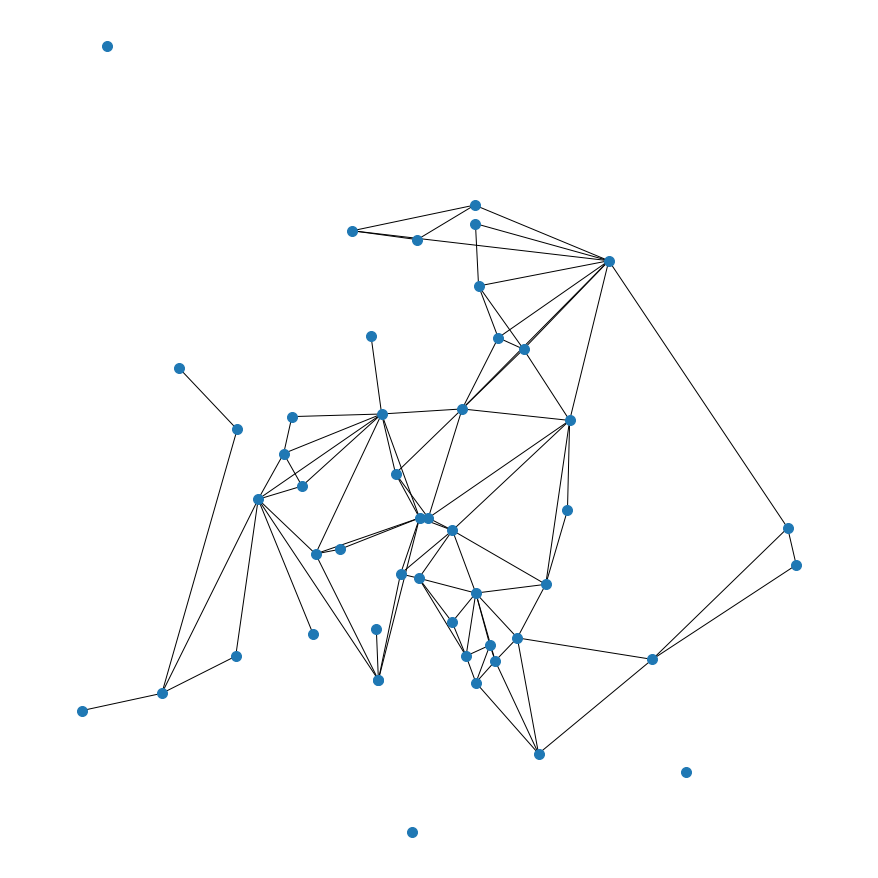

In [252]:
g = nx.Graph()
for _, row in df.iterrows():
    g.add_node(row['Country'], pos=(row['X'], row['Y']))

for index, row in df.iterrows():
    if isinstance(row['Borders'], list): 
        for i in range(len(row['Borders'])):
            g.add_edge(row['Country'], row['Borders'][i])

pos = nx.get_node_attributes(g, 'pos')

plt.figure(1, figsize=(12, 12))
nx.draw(g, pos, with_labels=False, node_size=100)
tikzplotlib.save('eurograph.tex')

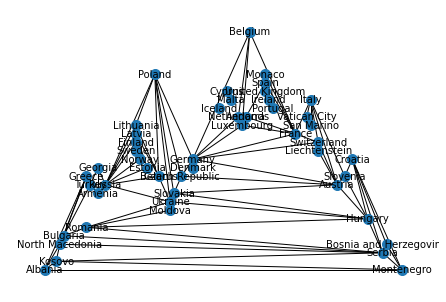

In [231]:
nx.draw_planar(g, with_labels=True, node_size=100, font_size=10)
tikzplotlib.save('eurograph.tex')
